In [1]:
# coding:u8
import pandas as pd
import numpy as np
import copy,gc
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score,classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import seaborn as sns



In [2]:
data = pd.read_pickle('features/1_stat_feature.pkl')

In [3]:
# data = data.fillna(-999)

In [4]:
data.head()

,text_id,kb_id,train_mention,label,num_attrs,num_abstract_words,num_alias,m_id,num_candidates,mention_equal_subject,...,rank_num_abstract_words,rank_num_alias,rank_label_mean,rank_label_count,rank_m_label_mean,rank_m_label_count,rank_num_candidates,rank_mention_equal_subject,rank_shuminghao,rank_entity_common
0,1,311223,南京南站,1,17,447,3,0,2,True,...,1.0,1.0,NaN,NaN,NaN,NaN,1.5,1.5,1.5,1.5
1,1,130287,南京南站,0,9,338,2,0,2,True,...,2.0,2.0,NaN,NaN,NaN,NaN,1.5,1.5,1.5,1.5
2,1,213561,高铁,0,1,0,2,1,2,False,...,2.0,1.0,2.0,1.5,2.0,1.5,1.5,2.0,1.5,2.0
3,1,341096,高铁,1,10,239,1,1,2,True,...,1.0,2.0,1.0,1.5,1.0,1.5,1.5,1.0,1.5,1.0
4,1,311223,南京南站,1,17,447,3,2,2,True,...,1.0,1.0,NaN,NaN,NaN,NaN,1.5,1.5,1.5,1.5


In [5]:

predictor = ['num_attrs',
       'num_abstract_words', 'num_alias', 'num_candidates',
       'mention_equal_subject', 'shuminghao', 'len_mention', 'mention_start',
       'academicdiscipline', 'animal', 'astronomicalobject', 'athlete',
       'awardeventseries', 'brand', 'building', 'collegeoruniversity',
       'communicationmedium', 'country', 'creativework', 'culturalheritage',
       'currency', 'curriculum', 'educationmajor', 'entertainmentperson',
       'event', 'familyname', 'fictionalhuman', 'fictionalthing', 'food',
       'formula', 'game', 'historicalperiod', 'historicalperson', 'human',
       'internationalorganization', 'language', 'material', 'medicalcondition',
       'medicaldepartmenttype', 'movie', 'nation', 'organism', 'organization',
       'person', 'place', 'plant', 'product', 'scientificorganization',
       'symbol', 'theorem', 'thing', 'tool', 'tvplay', 'tvshow', 'vocabulary',
       'zodiacsign', 'label_mean', 'label_count', 'm_label_mean',
       'm_label_count', 'rank_num_attrs', 'rank_num_abstract_words',
       'rank_num_alias', 'rank_label_mean', 'rank_label_count',
       'rank_m_label_mean', 'rank_m_label_count', 'rank_num_candidates',
       'rank_mention_equal_subject', 'rank_shuminghao', 'rank_entity_common','entity_common']

In [6]:
exclude = []
# exclude = []
temp = []
for x in predictor:
    if x not in exclude:temp.append(x)
predictor2 = temp

In [7]:
param = {
    #'num_leaves':100,
    'objective':'binary',
    #'metric':'acc',
    'metric_freq':20,
    'learning_rate': 0.05,
    'num_threads':8,
    #'min_sum_hessian_in_leaf':10,
    'boosting_type':'gbdt',
    'subsample':0.9,
    'colsample_bytree':0.8,
    'n_estimators':20000,
    'min_child_weight':1,
    'subsample_freq':2,
    'num_leaves':128,
    'n_jobs':-1,
}


In [10]:
data['m_id'].nunique()

269361

In [11]:
sum(data.groupby('m_id')['label'].sum())

257078

In [15]:
kfold = KFold(n_splits=9,shuffle=False,random_state=2019)
for train_index,test_index in kfold.split(data):
    train_data,val_data = data.loc[train_index,:],data.loc[test_index,:]
    train_data = train_data.fillna(-999)
    train = lgb.Dataset(train_data[predictor2],label=train_data['label'])
    validation_data = lgb.Dataset(val_data[predictor2],label=val_data['label'])
    
    val_data.reset_index(inplace=True,drop=True)
    val_data.reset_index(inplace=True)
    index_df = val_data.groupby('m_id')['index'].apply(list)
    
    label_package = val_data.groupby('m_id',as_index=False)['label'].agg({'label_id_max':'idxmax'})['label_id_max']
    
    def lgb_f1_score(y_hat, data):
        y_true = data.get_label()
        span = list(np.linspace(0,1, 100))
        scores = []
        for i in span:
            predict_y =  np.where(y_hat >= i, 1,0)
            score = f1_score(y_true, predict_y)
            scores.append(score)
        #print(scores)
        best_score = max(scores)
        return 'f1', best_score, True
    bst = lgb.train(param, train, valid_sets=[validation_data],early_stopping_rounds=500,
                    verbose_eval=20,feval=lgb_f1_score)
    
    # 观察阈值
#     val_data['link_grade'] = bst.predict(val_data[predictor2])
#     max_id = val_data.groupby('m_id',as_index=False)['link_grade'].agg({'max_id':'idxmax'})['max_id']
#     val_data_temp = val_data.loc[max_id,:]
#     # 假设label为１的数据有0.84的概率为真
#     m = 0
#     n = 0
#     hit = 0
#     for i in range(100):
#         i = i/100
#         filter_val = val_data_temp[val_data_temp['link_grade']>i]
#         m = filter_val.shape[0]
#         n = 28000
#         hit = filter_val['label'].mean()*m*0.83
#         acc = hit/m
#         recall = hit/n
#         f1 = 2*acc*recall/(acc+recall)
#         print(f1,acc,recall,i)
        
# 0.8672
# 0.872
# [171]	valid_0's binary_logloss: 0.0988336	valid_0's acc: 0.873219
# valid_0's binary_logloss: 0.0964686	valid_0's acc: 0.87713
# [224]	valid_0's binary_logloss: 0.096617	valid_0's acc: 0.877515
# [308]	valid_0's binary_logloss: 0.09149	valid_0's acc: 0.890507 entity common
# drop ctr 0.877
# [2094]	valid_0's binary_logloss: 0.0791409	valid_0's acc: 0.896452
# [1674]	valid_0's binary_logloss: 0.0784442	valid_0's acc: 0.896347
#０．９１５
# [1344]	valid_0's binary_logloss: 0.0767459	valid_0's acc: 0.897395
# [405]	valid_0's binary_logloss: 0.0681472	valid_0's acc: 0.913129
# [1600]	valid_0's binary_logloss: 0.0672695	valid_0's acc: 0.91415


Training until validation scores don't improve for 500 rounds.
[20]	valid_0's binary_logloss: 0.153515	valid_0's f1: 0.890509
[40]	valid_0's binary_logloss: 0.103224	valid_0's f1: 0.891948
[60]	valid_0's binary_logloss: 0.0867161	valid_0's f1: 0.893134
[80]	valid_0's binary_logloss: 0.0807173	valid_0's f1: 0.893802
[100]	valid_0's binary_logloss: 0.0780483	valid_0's f1: 0.894843
[120]	valid_0's binary_logloss: 0.0768208	valid_0's f1: 0.895859
[140]	valid_0's binary_logloss: 0.0761305	valid_0's f1: 0.895966
[160]	valid_0's binary_logloss: 0.0757658	valid_0's f1: 0.896202
[180]	valid_0's binary_logloss: 0.0755606	valid_0's f1: 0.896315
[200]	valid_0's binary_logloss: 0.0754194	valid_0's f1: 0.896462
[220]	valid_0's binary_logloss: 0.0752713	valid_0's f1: 0.896519
[240]	valid_0's binary_logloss: 0.0751575	valid_0's f1: 0.896581
[260]	valid_0's binary_logloss: 0.0750681	valid_0's f1: 0.896758
[280]	valid_0's binary_logloss: 0.0749552	valid_0's f1: 0.89701
[300]	valid_0's binary_logloss: 0.

[2520]	valid_0's binary_logloss: 0.0734675	valid_0's f1: 0.900466
[2540]	valid_0's binary_logloss: 0.0734546	valid_0's f1: 0.900453
[2560]	valid_0's binary_logloss: 0.0734751	valid_0's f1: 0.900423
[2580]	valid_0's binary_logloss: 0.0734804	valid_0's f1: 0.900436
[2600]	valid_0's binary_logloss: 0.0735016	valid_0's f1: 0.900568
[2620]	valid_0's binary_logloss: 0.0735079	valid_0's f1: 0.900515
[2640]	valid_0's binary_logloss: 0.0735019	valid_0's f1: 0.900678
[2660]	valid_0's binary_logloss: 0.0735089	valid_0's f1: 0.900808
Early stopping, best iteration is:
[2176]	valid_0's binary_logloss: 0.0733918	valid_0's f1: 0.900178
Training until validation scores don't improve for 500 rounds.
[20]	valid_0's binary_logloss: 0.152344	valid_0's f1: 0.889808
[40]	valid_0's binary_logloss: 0.102512	valid_0's f1: 0.89222
[60]	valid_0's binary_logloss: 0.0860349	valid_0's f1: 0.893607
[80]	valid_0's binary_logloss: 0.0801898	valid_0's f1: 0.89468
[100]	valid_0's binary_logloss: 0.0776094	valid_0's f1: 

[2340]	valid_0's binary_logloss: 0.0721125	valid_0's f1: 0.901517
[2360]	valid_0's binary_logloss: 0.0720999	valid_0's f1: 0.901697
[2380]	valid_0's binary_logloss: 0.072101	valid_0's f1: 0.901744
[2400]	valid_0's binary_logloss: 0.0721218	valid_0's f1: 0.901694
Early stopping, best iteration is:
[1915]	valid_0's binary_logloss: 0.0721386	valid_0's f1: 0.901999
Training until validation scores don't improve for 500 rounds.
[20]	valid_0's binary_logloss: 0.151648	valid_0's f1: 0.891576
[40]	valid_0's binary_logloss: 0.10169	valid_0's f1: 0.893459
[60]	valid_0's binary_logloss: 0.0850354	valid_0's f1: 0.894174
[80]	valid_0's binary_logloss: 0.0786977	valid_0's f1: 0.895037
[100]	valid_0's binary_logloss: 0.0760015	valid_0's f1: 0.895532
[120]	valid_0's binary_logloss: 0.0746203	valid_0's f1: 0.895963
[140]	valid_0's binary_logloss: 0.0739091	valid_0's f1: 0.896378
[160]	valid_0's binary_logloss: 0.0734616	valid_0's f1: 0.897125
[180]	valid_0's binary_logloss: 0.073203	valid_0's f1: 0.897

[2420]	valid_0's binary_logloss: 0.070502	valid_0's f1: 0.900452
[2440]	valid_0's binary_logloss: 0.0705129	valid_0's f1: 0.900406
[2460]	valid_0's binary_logloss: 0.0705134	valid_0's f1: 0.90042
[2480]	valid_0's binary_logloss: 0.0705158	valid_0's f1: 0.900367
[2500]	valid_0's binary_logloss: 0.0705298	valid_0's f1: 0.900427
[2520]	valid_0's binary_logloss: 0.0705285	valid_0's f1: 0.90049
[2540]	valid_0's binary_logloss: 0.0705325	valid_0's f1: 0.900435
[2560]	valid_0's binary_logloss: 0.0705449	valid_0's f1: 0.900544
[2580]	valid_0's binary_logloss: 0.0705436	valid_0's f1: 0.900463
[2600]	valid_0's binary_logloss: 0.0705546	valid_0's f1: 0.900497
[2620]	valid_0's binary_logloss: 0.0705488	valid_0's f1: 0.900561
[2640]	valid_0's binary_logloss: 0.0705389	valid_0's f1: 0.900582
[2660]	valid_0's binary_logloss: 0.0705486	valid_0's f1: 0.900591
[2680]	valid_0's binary_logloss: 0.0705597	valid_0's f1: 0.900604
[2700]	valid_0's binary_logloss: 0.0705513	valid_0's f1: 0.900613
[2720]	valid_

[2020]	valid_0's binary_logloss: 0.0742483	valid_0's f1: 0.898615
[2040]	valid_0's binary_logloss: 0.0742288	valid_0's f1: 0.898704
[2060]	valid_0's binary_logloss: 0.0742383	valid_0's f1: 0.898788
[2080]	valid_0's binary_logloss: 0.0742171	valid_0's f1: 0.89874
[2100]	valid_0's binary_logloss: 0.0742242	valid_0's f1: 0.898702
[2120]	valid_0's binary_logloss: 0.0742195	valid_0's f1: 0.898663
[2140]	valid_0's binary_logloss: 0.0742244	valid_0's f1: 0.898798
[2160]	valid_0's binary_logloss: 0.0742202	valid_0's f1: 0.898811
[2180]	valid_0's binary_logloss: 0.0741965	valid_0's f1: 0.898915
[2200]	valid_0's binary_logloss: 0.074196	valid_0's f1: 0.898763
[2220]	valid_0's binary_logloss: 0.0742074	valid_0's f1: 0.898827
[2240]	valid_0's binary_logloss: 0.0742008	valid_0's f1: 0.898857
[2260]	valid_0's binary_logloss: 0.0742061	valid_0's f1: 0.898996
[2280]	valid_0's binary_logloss: 0.074208	valid_0's f1: 0.899064
[2300]	valid_0's binary_logloss: 0.0742128	valid_0's f1: 0.899145
[2320]	valid_

[1800]	valid_0's binary_logloss: 0.0734591	valid_0's f1: 0.898014
[1820]	valid_0's binary_logloss: 0.0734663	valid_0's f1: 0.898119
[1840]	valid_0's binary_logloss: 0.0734684	valid_0's f1: 0.898119
[1860]	valid_0's binary_logloss: 0.0734876	valid_0's f1: 0.898163
[1880]	valid_0's binary_logloss: 0.0734836	valid_0's f1: 0.898087
[1900]	valid_0's binary_logloss: 0.0734803	valid_0's f1: 0.898141
[1920]	valid_0's binary_logloss: 0.0734906	valid_0's f1: 0.898237
[1940]	valid_0's binary_logloss: 0.0735007	valid_0's f1: 0.898363
[1960]	valid_0's binary_logloss: 0.0734993	valid_0's f1: 0.898444
[1980]	valid_0's binary_logloss: 0.0734999	valid_0's f1: 0.898356
[2000]	valid_0's binary_logloss: 0.0735024	valid_0's f1: 0.898355
[2020]	valid_0's binary_logloss: 0.073499	valid_0's f1: 0.898426
[2040]	valid_0's binary_logloss: 0.0734889	valid_0's f1: 0.898453
[2060]	valid_0's binary_logloss: 0.0734824	valid_0's f1: 0.898555
[2080]	valid_0's binary_logloss: 0.0734772	valid_0's f1: 0.898674
[2100]	vali

KeyboardInterrupt: 

In [ ]:
def lgb_f1_score(y_hat, data):
        y_true = data.get_label()
        span = list(np.linspace(0,1, 100))
        scores = []
        for i in span:
            predict_y =  np.where(y_hat >= i, 1,0)
            score = f1_score(y_true, predict_y)
            scores.append(score)
        #print(scores)
        best_score = max(scores)

In [16]:
pred = bst.predict(val_data[predictor2])

In [18]:
span = list(np.linspace(0,1, 100))
scores = []
for i in span:
    predict_y =  np.where(pred >= i, 1,0)
    score = f1_score(val_data['label'], predict_y)
    print(i,score)
    scores.append(score)
best_score = max(scores)
scores.index(best_score)

0.0 0.24282513143152634
0.010101010101010102 0.6866886876394086
0.020202020202020204 0.7486840006380603
0.030303030303030304 0.7842672834173935
0.04040404040404041 0.8068217676927047
0.05050505050505051 0.824207239301579
0.06060606060606061 0.8383746437258442
0.07070707070707072 0.8493747918495868
0.08080808080808081 0.8592447278077489
0.09090909090909091 0.8682978261543709
0.10101010101010102 0.8753031749260646
0.11111111111111112 0.8818191860373369
0.12121212121212122 0.8875071560333312
0.13131313131313133 0.8925963878570513
0.14141414141414144 0.8968127425874924
0.15151515151515152 0.9007660787457688
0.16161616161616163 0.9040471461596067
0.17171717171717174 0.9075058473314905
0.18181818181818182 0.9106177384102151
0.19191919191919193 0.9133039560330742
0.20202020202020204 0.915434419035949
0.21212121212121213 0.9181871101871102
0.22222222222222224 0.9203652083924487
0.23232323232323235 0.9226207428006633
0.24242424242424243 0.9241555559291827
0.25252525252525254 0.9257985092245945


44

In [54]:
############################## for submit  #####################################

train = lgb.Dataset(data[predictor2],label=data['label'])
param = {
    #'num_leaves':100,
    'objective':'binary',
    #'metric':'acc',
    'metric_freq':20,
    'learning_rate': 0.05,
    'num_threads':8,
    #'min_sum_hessian_in_leaf':10,
    'boosting_type':'gbdt',
    'subsample':0.9,
    'colsample_bytree':0.8,
    'n_estimators':500,
    'min_child_weight':1,
    'subsample_freq':2,
    'num_leaves':128,
    'n_jobs':-1,
}

bst = lgb.train(param, train)
from sklearn.externals import joblib
joblib.dump(bst, 'model_link/lgb.pkl')

# save model
# load model
#gbm_pickle = joblib.load('lgb.pkl')
# break

/home/zhukaihua/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


['model_link/lgb.pkl']

In [ ]:
# val_data

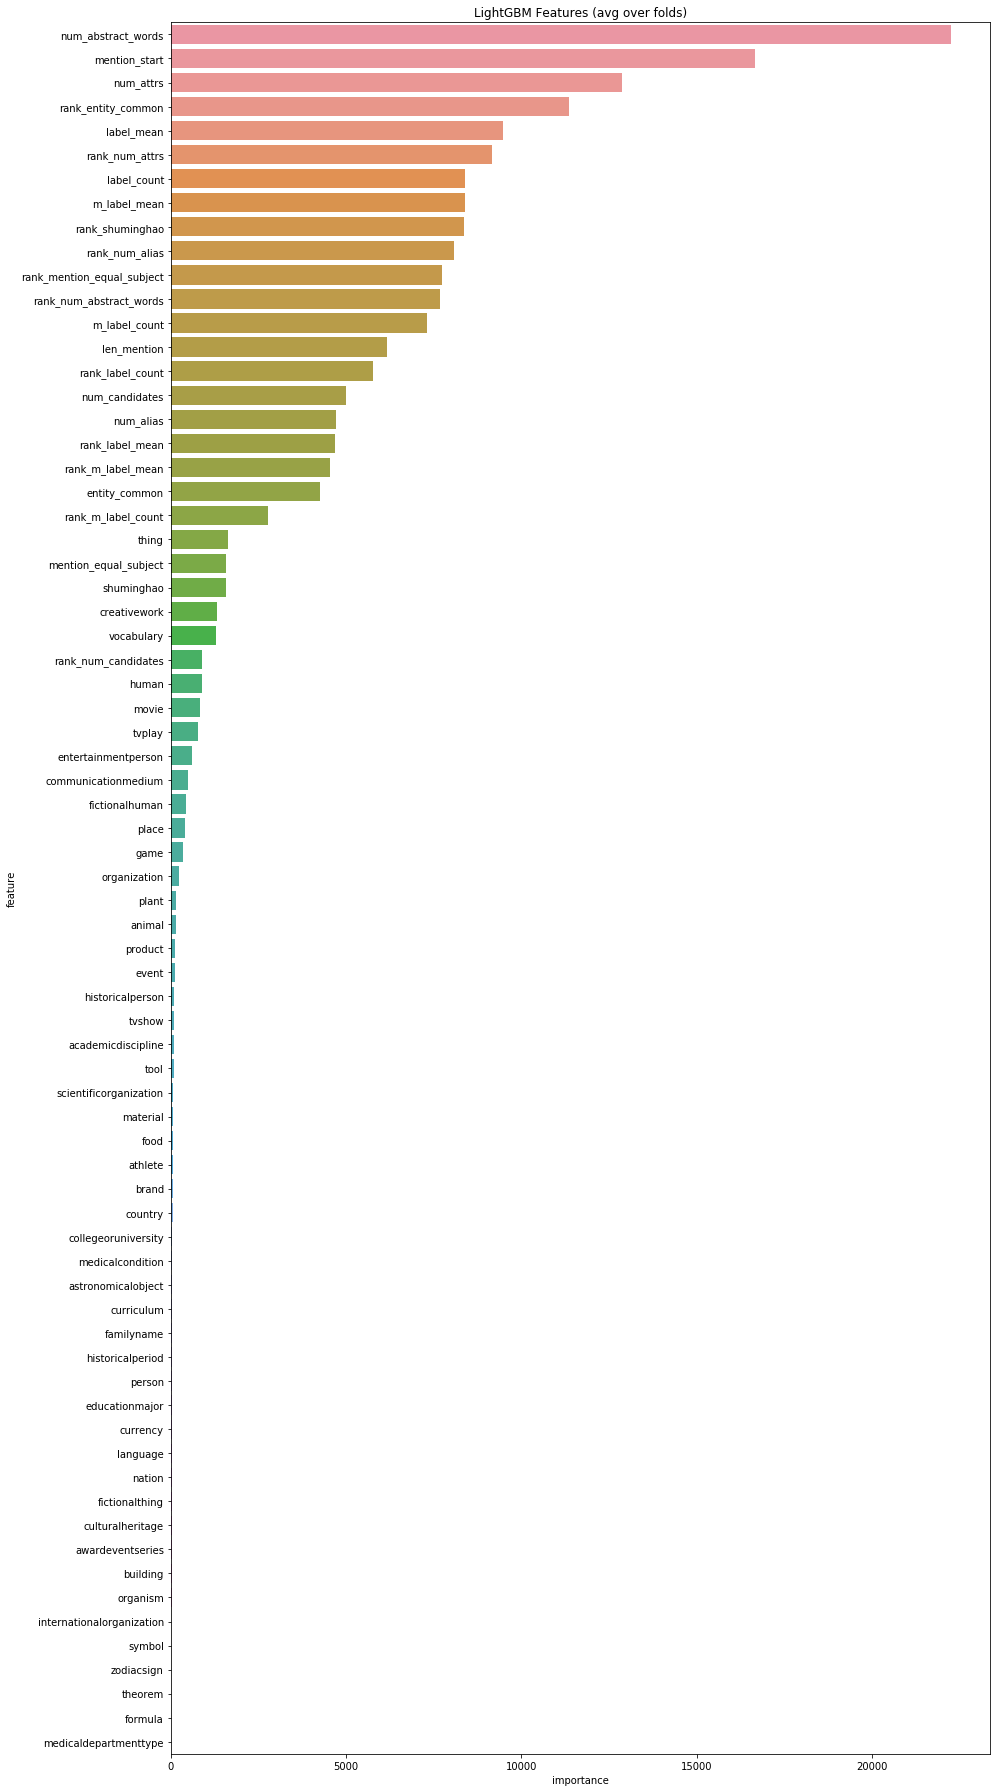

In [15]:
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = predictor2
fold_importance_df["importance"] = bst.feature_importance()
cols = (fold_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = fold_importance_df.loc[fold_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [ ]:
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = predictor2
fold_importance_df["importance"] = bst.feature_importance()
cols = (fold_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = fold_importance_df.loc[fold_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')